In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df_cars = pd.read_csv(r'C:\Users\v_gol\Desktop\car-price-prediction-israel\data\yad2_data.csv')

# Remove rows where 'horse_power' is missing
df_cars = df_cars[df_cars['horse_power'].notna()]

# Summary of the data
df_cars.describe()

,price,year,hand_num,horse_power,4x4,engine_volume,valid_test,magnesium_wheels,distance_control,economical,adaptive_cruise_control,cruise_control
count,15140.000000,15140.000000,15140.000000,15140.000000,15140.000000,14631.000000,15140.000000,15140.000000,15140.000000,15140.000000,15140.000000,15140.000000
mean,69936.047622,2016.206605,2.124174,152.809379,0.153633,1.814948,0.220476,0.318362,0.232299,0.131242,0.112351,0.112682
std,53176.818593,4.578486,1.245868,65.814482,0.360608,0.704439,0.414581,0.465856,0.422312,0.337676,0.315809,0.316214
min,200.000000,1990.000000,0.000000,0.000000,0.000000,0.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25300.000000,2013.750000,1.000000,110.000000,0.000000,1.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,62000.000000,2017.000000,2.000000,140.000000,0.000000,1.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,99900.000000,2020.000000,3.000000,170.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,235000.000000,2024.000000,10.000000,1000.000000,1.000000,6.700000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df_cars.columns

Index(['brand', 'model', 'car_name', 'price', 'year', 'hand_num',
       'horse_power', '4x4', 'fuel_type', 'engine_volume', 'valid_test',
       'magnesium_wheels', 'distance_control', 'economical',
       'adaptive_cruise_control', 'cruise_control', 'brand_normalized',
       'brand_group'],
      dtype='object')

In [89]:
df_cars.to_csv('C:/Users/v_gol/Desktop/Developers Institute/Car_price_prediction_bot/Israels-Car-price-predictor-Telegramm-Bot/Data-cleaning-preprocessing/final_data_14-01-25_v3.csv', index=False)

In [6]:
# Create a new column 'electric_or_not' based on the 'fuel_type' column
df_cars['electric_or_not'] = df_cars['fuel_type'].apply(lambda x: 'Electric' if x == 'electric' else 'Not Electric')

# Display the first few rows to verify
print(df_cars[['fuel_type', 'electric_or_not']].head())

  fuel_type electric_or_not
0    hybrid    Not Electric
1    petrol    Not Electric
2    petrol    Not Electric
3    petrol    Not Electric
4    petrol    Not Electric


In [8]:
# Check normality of price using Shapiro-Wilk test on a sample
price_sample = df_cars['price'].sample(n=5000, random_state=123)
_, p_value = stats.shapiro(price_sample)
print(f"Shapiro-Wilk test for price: p-value = {p_value}")

# Print results of the test according to p-value
if p_value > 0.05:
    print("The null hypothesis cannot be rejected. The sample data is normally distributed.")
else:
    print("The null hypothesis is rejected. The sample data is not normally distributed.")

Shapiro-Wilk test for price: p-value = 3.673777916658969e-43
The null hypothesis is rejected. The sample data is not normally distributed.


Shapiro-Wilk test for log-transformed price: p-value = 1.655307316527781e-48


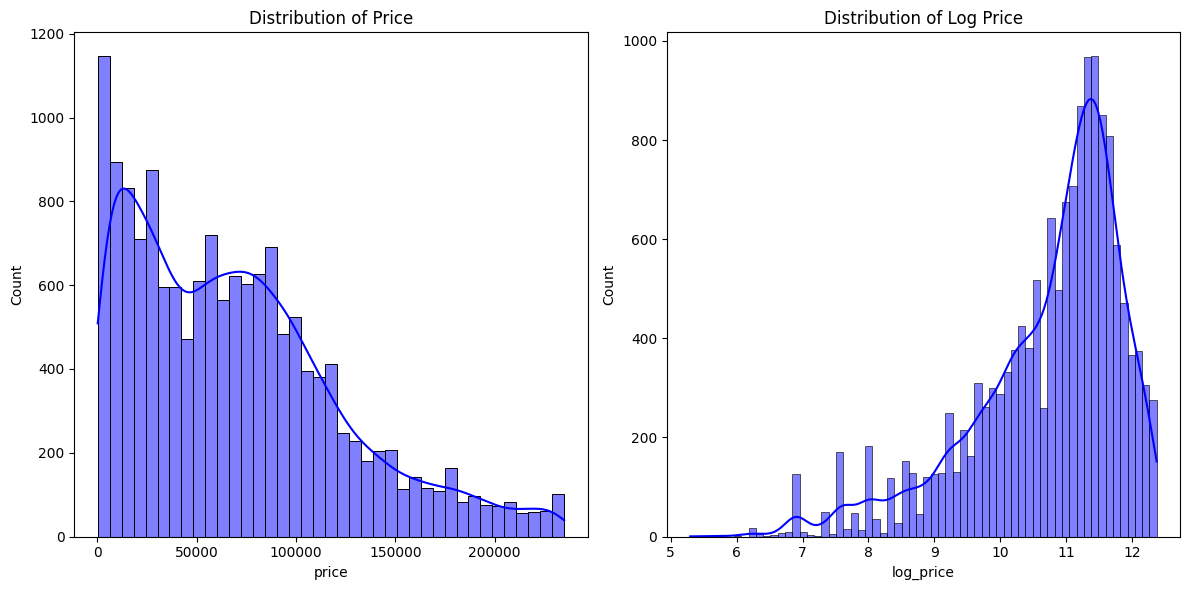

In [9]:
# Log transformation if price is skewed
df_cars['log_price'] = np.log(df_cars['price'])

# Check normality of log-transformed price
log_price_sample = df_cars['log_price'].sample(n=5000, random_state=123)
_, p_value = stats.shapiro(log_price_sample)
print(f"Shapiro-Wilk test for log-transformed price: p-value = {p_value}")

# Plot distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_cars['price'], kde=True, color='blue')
plt.title('Distribution of Price')

plt.subplot(1, 2, 2)
sns.histplot(df_cars['log_price'], kde=True, color='blue')
plt.title('Distribution of Log Price')
plt.tight_layout()
plt.show()

In [10]:
# Fit a robust linear model
formula = 'log_price ~ year + hand_num + horse_power + Q("4x4") + fuel_type + engine_volume + valid_test + brand_group'
model_robust = smf.rlm(formula, data=df_cars).fit()
print(model_robust.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:              log_price   No. Observations:                14631
Model:                            RLM   Df Residuals:                    14619
Method:                          IRLS   Df Model:                           11
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 16 Jan 2025                                         
Time:                        16:05:34                                         
No. Iterations:                    41                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -281.01

In [11]:
from patsy import dmatrix

# Check for multicollinearity
X = df_cars[['year', 'hand_num', 'horse_power', "4x4", 'fuel_type', 'engine_volume', 'valid_test', 'brand_group']]
X = pd.get_dummies(X, drop_first=True)  # Convert categorical variables to dummy variables

# Rename column "4x4" to a valid identifier
X = X.rename(columns={"4x4": "X4x4"})

# Convert boolean columns to integers
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

# Handle missing values by filling with the mean of the column
X = X.fillna(X.mean())

vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


              Variable        VIF
0                 year  20.661169
1             hand_num   4.249223
2          horse_power  17.134594
3                 X4x4   1.653118
4        engine_volume  17.621667
5           valid_test   1.321964
6   fuel_type_electric   1.758001
7     fuel_type_hybrid   1.782286
8     fuel_type_petrol   6.537720
9   brand_group_Luxury   1.558365
10   brand_group_Other   1.699676


In [12]:
# Breusch-Pagan test for heteroscedasticity
_, p_value, _, _ = het_breuschpagan(model_robust.resid, model_robust.model.exog)
print(f"Breusch-Pagan test for heteroscedasticity: p-value = {p_value}")
if p_value > 0.05:
    print("The null hypothesis cannot be rejected. There is no evidence of heteroscedasticity.")
else:
    print("The null hypothesis is rejected. There is evidence of heteroscedasticity.")

Breusch-Pagan test for heteroscedasticity: p-value = 4.580621227318703e-50
The null hypothesis is rejected. There is evidence of heteroscedasticity.


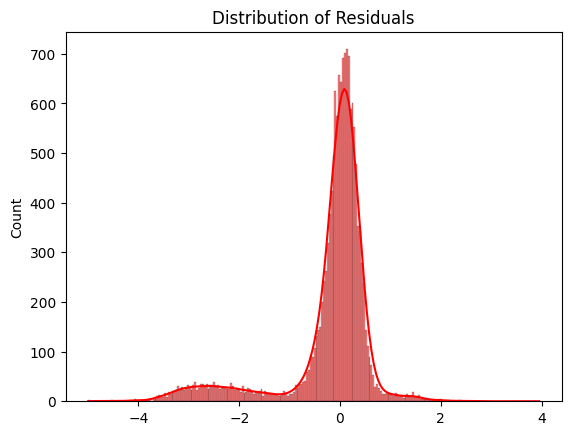

In [13]:
# Plot residuals for normality
sns.histplot(model_robust.resid, kde=True, color='red')
plt.title('Distribution of Residuals')
plt.show()

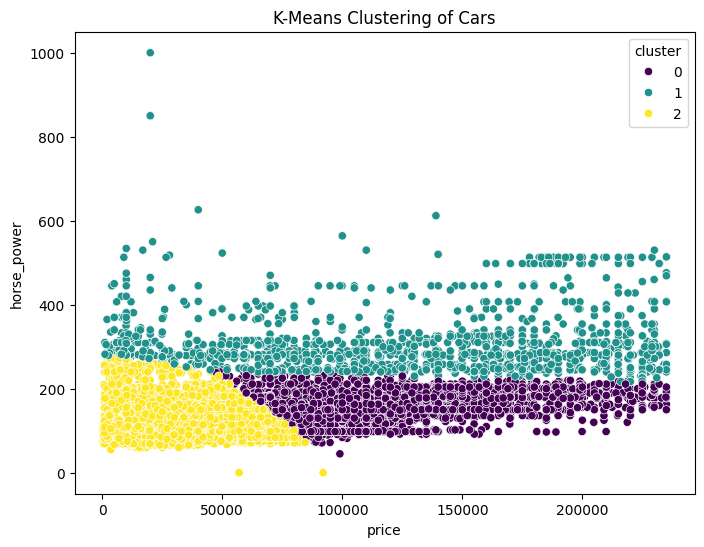

                    Robust linear Model Regression Results                    
Dep. Variable:              log_price   No. Observations:                15140
Model:                            RLM   Df Residuals:                    15130
Method:                          IRLS   Df Model:                            9
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 16 Jan 2025                                         
Time:                        16:08:22                                         
No. Iterations:                    24                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -205.50

In [14]:
# Scale features for clustering
features = df_cars[['price', 'horse_power']].dropna()
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=123)
df_cars['cluster'] = kmeans.fit_predict(features_scaled)

# Plot clustering results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cars, x='price', y='horse_power', hue='cluster', palette='viridis')
plt.title('K-Means Clustering of Cars')
plt.show()

# Fit model with clustering variable
model_robust_with_cluster = smf.rlm('log_price ~ year + hand_num + horse_power + Q("4x4") + fuel_type + valid_test + cluster', data=df_cars).fit()
print(model_robust_with_cluster.summary())

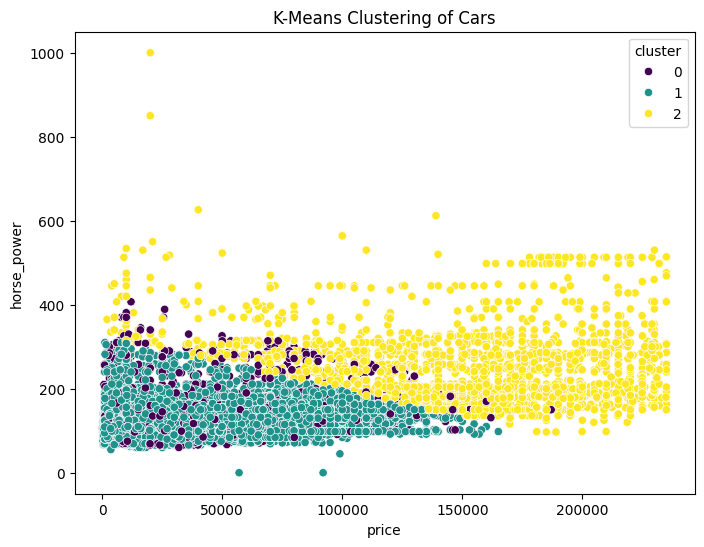

                    Robust linear Model Regression Results                    
Dep. Variable:              log_price   No. Observations:                15140
Model:                            RLM   Df Residuals:                    15130
Method:                          IRLS   Df Model:                            9
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 15 Jan 2025                                         
Time:                        15:36:56                                         
No. Iterations:                    32                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -266.25

In [78]:
# Scale features for clustering
features = df_cars[['price', 'horse_power','valid_test']].dropna()
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=123)
df_cars['cluster'] = kmeans.fit_predict(features_scaled)

# Plot clustering results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cars, x='price', y='horse_power', hue='cluster', palette='viridis')
plt.title('K-Means Clustering of Cars')
plt.show()

# Fit model with clustering variable
model_robust_with_cluster = smf.rlm('log_price ~ year + hand_num + horse_power + Q("4x4") + fuel_type + valid_test + cluster', data=df_cars).fit()
print(model_robust_with_cluster.summary())

In [15]:
# Define cluster labels
cluster_labels = {0: 'Premium', 1: 'Luxury', 2: 'Budget'}

# Create a new column 'cluster_label' based on the 'cluster' column
df_cars['cluster_label'] = df_cars['cluster'].map(cluster_labels)

# Display the first few rows to verify
print(df_cars[['cluster', 'cluster_label']].head())

   cluster cluster_label
0        0       Premium
1        0       Premium
2        1        Luxury
3        0       Premium
4        0       Premium


In [16]:
# Calculate car age
df_cars['car_age'] = 2024 - df_cars['year']

# Create training and test sets
trainData, testData = train_test_split(df_cars, test_size=0.2, random_state=123)

# Fit the model using the training data
model = smf.ols(formula='log_price ~ car_age + horse_power + Q("4x4") + cluster + valid_test + electric_or_not', data=trainData).fit()

# Calculate robust standard errors
robust_se = model.get_robustcov_results(cov_type='HC1')
print(robust_se.summary())

# Predictions on test set
predictions = model.predict(testData)

# Calculate RMSE and R-squared
rmse = np.sqrt(mean_squared_error(testData['log_price'], predictions))
r_squared = r2_score(testData['log_price'], predictions)
print(f"RMSE: {rmse}")
print(f"R-squared: {r_squared}")

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     2957.
Date:                Thu, 16 Jan 2025   Prob (F-statistic):               0.00
Time:                        16:08:43   Log-Likelihood:                -14243.
No. Observations:               12112   AIC:                         2.850e+04
Df Residuals:                   12105   BIC:                         2.855e+04
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Standard Deviation of Residuals: 0.8266846752567621


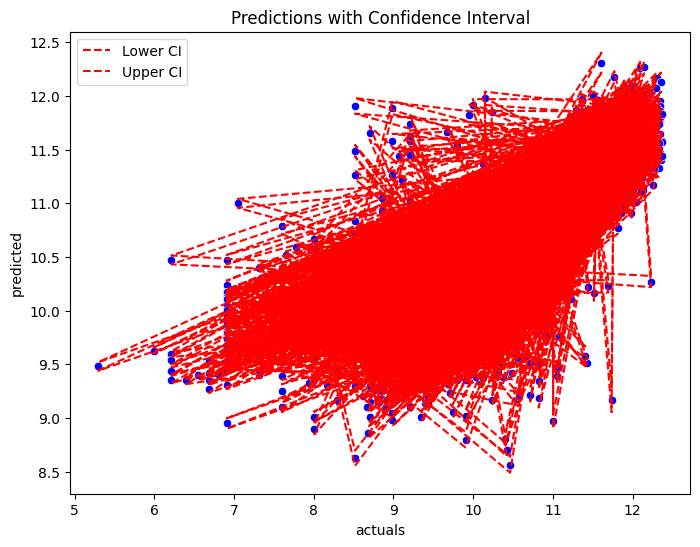

In [155]:
# Calculate residuals and standard deviation of residuals
residuals = testData['log_price'] - predictions
std_dev_residuals = np.std(residuals)
print(f"Standard Deviation of Residuals: {std_dev_residuals}")

# Get predictions with confidence intervals
predictions_with_ci = model.get_prediction(testData).conf_int()

# Create a DataFrame for plotting
predictions_df = pd.DataFrame({
    'actuals': testData['log_price'],
    'predicted': predictions,
    'lower': predictions_with_ci[:, 0],
    'upper': predictions_with_ci[:, 1]
})

# Plot predictions with confidence intervals
plt.figure(figsize=(8, 6))
sns.scatterplot(data=predictions_df, x='actuals', y='predicted', color='blue')
plt.plot(predictions_df['actuals'], predictions_df['lower'], 'r--', label='Lower CI')
plt.plot(predictions_df['actuals'], predictions_df['upper'], 'r--', label='Upper CI')
plt.title('Predictions with Confidence Interval')
plt.legend()
plt.show()


In [18]:
# Predict for a new car
new_car = pd.DataFrame({
    'car_age': [6],  # Example: 7 years old
    'horse_power': [110],  # Example: 125 horsepower
    '4x4': [0],  # Example: 4x4 feature
    'cluster': [2],  # 0- premium segment, 1- luxury segment, 2- budget segment
    'valid_test': [1],  # Example: valid test
    'electric_or_not': ['Not Electric']  # Example: not electric
})

prediction_with_ci = model.get_prediction(new_car).summary_frame(alpha=0.05)
predicted_price = np.exp(prediction_with_ci['mean'][0])
lower_bound = np.exp(prediction_with_ci['mean_ci_lower'][0])
upper_bound = np.exp(prediction_with_ci['mean_ci_upper'][0])

print('Decoding segment: 0 - Premium, 1 - Luxury, 2 - Budget')
print(f"Predicted Price for a car with age {new_car['car_age'][0]} years and {new_car['horse_power'][0]} horse power in the {new_car['cluster'][0]} segment: NIS {predicted_price:,.2f}")
print(f"95% Confidence Interval: NIS {lower_bound:,.2f} - NIS {upper_bound:,.2f}")

Decoding segment: 0 - Premium, 1 - Luxury, 2 - Budget
Predicted Price for a car with age 6 years and 110 horse power in the 2 segment: NIS 31,347.60
95% Confidence Interval: NIS 30,249.48 - NIS 32,485.59


In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Check for multicollinearity
X = df_cars[['car_age', 'horse_power', "4x4", 'cluster', 'valid_test', 'electric_or_not']]
X = pd.get_dummies(X, drop_first=True)  # Convert categorical variables to dummy variables

# Rename column "4x4" to a valid identifier
X = X.rename(columns={"4x4": "X4x4"})

# Convert boolean columns to integers
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

# Handle missing values by filling with the mean of the column
X = X.fillna(X.mean())

vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                       Variable       VIF
0                       car_age  5.665301
1                   horse_power  4.771533
2                          X4x4  1.484868
3                       cluster  3.628481
4                    valid_test  1.326402
5  electric_or_not_Not Electric  6.413382


Crossvalidation

In [158]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

# Load dataset
df_cars = pd.read_csv('C:/Users/v_gol/Desktop/Developers Institute/Car_price_prediction_bot/Israels-Car-price-predictor-Telegramm-Bot/Data-cleaning-preprocessing/final_data_14-01-25_v3.csv')

# Remove rows where 'horse_power' is missing
df_cars = df_cars[df_cars['horse_power'].notna()]

# Rename column "4x4" to a valid identifier
df_cars = df_cars.rename(columns={"4x4": "X4x4"})

# Calculate car age
df_cars['car_age'] = 2024 - df_cars['year']

# Define the formula
formula = 'log_price ~ car_age + horse_power + Q("X4x4") + cluster + valid_test + electric_or_not'

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=123)
rmse_scores = []

for train_index, test_index in kf.split(df_cars):
    train_data = df_cars.iloc[train_index]
    test_data = df_cars.iloc[test_index]
    
    model = smf.ols(formula=formula, data=train_data).fit()
    predictions = model.predict(test_data)
    rmse = np.sqrt(mean_squared_error(test_data['log_price'], predictions))
    rmse_scores.append(rmse)

# Calculate Mean RMSE and Standard Deviation of RMSE
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

print(f"Cross-Validation RMSE Scores: {rmse_scores}")
print(f"Mean RMSE: {mean_rmse}")
print(f"Standard Deviation of RMSE: {std_rmse}")

Cross-Validation RMSE Scores: [np.float64(0.8272628834071317), np.float64(0.7656150653292905), np.float64(0.7981029164256064), np.float64(0.7870859593578364), np.float64(0.7878991055102765)]
Mean RMSE: 0.7931931860060283
Standard Deviation of RMSE: 0.020053568158730665


In [19]:
import pickle
import os

# Define the path to the models directory
models_dir = r'C:\Users\v_gol\Desktop\car-price-prediction-israel\models'

# Save the trained model in the models directory
model_path = os.path.join(models_dir, 'trained_model_glm_yad2.pkl')
with open(model_path, 'wb') as model_file:
    pickle.dump(model, model_file)

print(f"Model saved successfully at {model_path}.")

Model saved successfully at C:\Users\v_gol\Desktop\car-price-prediction-israel\models\trained_model_glm_yad2.pkl.
